# Acidentes de Trânsito em Santa Catarina

# 0- Setup e Carregamento do Conjunto de Dados

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 0.1 Funções Auxiliares

In [4]:
def make_number_of_accidents_df(data):
    
    contagem_acidentes = []
    contagem_acidentes_fatais = []
    
    for veiculo in data['tipo_veiculo'].unique():
        
        tabela_veiculo = data.loc[data['tipo_veiculo'] == veiculo]
        mortos = tabela_veiculo.loc[tabela_veiculo['mortos'] == 1]
        
        numero_acidentes = tabela_veiculo.shape[0]
        numero_acidentes_fatais = np.sum(mortos['mortos'])    
    
        contagem_acidentes.append(numero_acidentes)  
        contagem_acidentes_fatais.append(numero_acidentes_fatais)
    
    dict = {'tipo_veiculo': data['tipo_veiculo'].unique(), 'numero_acidentes': contagem_acidentes, 'acidentes_fatais': contagem_acidentes_fatais}
    acidentes_fatais_por_veiculo_df = pd.DataFrame(dict)

    return acidentes_fatais_por_veiculo_df

def get_anova_table(df, numeric_column, class_column):

    model = ols(numeric_column + ' ~ ' + class_column, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    f_statistic, p_value, class_degf, res_degf = anova_table.F[0], anova_table['PR(>F)'][0], anova_table.df[0], anova_table.df[1]

    return f_statistic, p_value, class_degf, res_degf

def perform_anova(df, numeric_column, class_column):
    # Group the data by class
    grouped_data = [group[numeric_column].values for name, group in df.groupby(class_column)]    
    
    # Perform one-way ANOVA
    f_statistic, p_value = stats.f_oneway(*grouped_data)
    
    return f_statistic, p_value

def show_descriptive_statistics(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean))
    ct2 = pd.DataFrame(df.apply(np.median))    

    # Dispersion - std, min, max, range
    d1 = pd.DataFrame(df.apply(np.std))
    d2 = pd.DataFrame(df.apply(min))
    d3 = pd.DataFrame(df.apply(max))
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))    

    m = pd.concat([d2, d3, d4, ct1, ct2, d1], axis = 1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std']    
    return m

In [5]:
# carregando o dataset raw e selecionando os datapoints de SC

current_path = os.getcwd()
acidentes_raw = pd.read_csv(current_path.replace('/notebooks', '') + '/data/raw/acidentes2023.csv', sep=';', encoding = "ISO-8859-1")
acidentes_sc_raw = acidentes_raw.loc[acidentes_raw['uf'] == 'SC']

In [6]:
# fazendo uma cópia e salvando um csv da parte selecionada do dataframe acima

acidentes_sc_1 = acidentes_sc_raw.copy()
acidentes_sc_1.reset_index(inplace=True)
acidentes_sc_1.to_csv(current_path.replace('/notebooks', '') + '/data/interim/acidentes_sc_1.csv')

In [67]:
acidentes_sc_1

,index,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,13,496772,1082749,2023-01-02,segunda-feira,07:23:00,SC,101,134,BALNEARIO CAMBORIU,...,Masculino,1,0,0,0,"-27,00218","-48,636433",SPRF-SC,DEL04-SC,UOP03-DEL04-SC
1,34,496875,1083269,2023-01-02,segunda-feira,17:25:00,SC,101,255,PAULO LOPES,...,Masculino,1,0,0,0,"-27,98242299","-48,67898469",SPRF-SC,DEL02-SC,UOP03-DEL02-SC
2,35,496877,1083209,2023-01-02,segunda-feira,17:15:00,SC,101,252,PAULO LOPES,...,Masculino,1,0,0,0,"-27,95672412","-48,6767588",SPRF-SC,DEL02-SC,UOP03-DEL02-SC
3,36,496877,1084656,2023-01-02,segunda-feira,17:15:00,SC,101,252,PAULO LOPES,...,Feminino,1,0,0,0,"-27,95672412","-48,6767588",SPRF-SC,DEL02-SC,UOP03-DEL02-SC
4,45,496922,1083214,2023-01-02,segunda-feira,22:30:00,SC,101,"8,9",GARUVA,...,Masculino,0,1,0,0,"-26,044942","-48,859703",SPRF-SC,DEL03-SC,UOP01-DEL03-SC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19681,183231,607433,1356245,2023-11-14,terça-feira,11:32:00,SC,282,"20,4",PALHOCA,...,Feminino,1,0,0,0,"-27,68689795","-48,71353263",SPRF-SC,DEL01-SC,UOP02-DEL01-SC
19682,183345,617175,1380488,2023-09-24,domingo,05:00:00,SC,470,"0,9",GASPAR,...,Masculino,0,1,0,0,"-26,92203838","-48,95884931",NaN,NaN,NaN
19683,183346,617175,1380489,2023-09-24,domingo,05:00:00,SC,470,"0,9",GASPAR,...,Masculino,0,0,1,0,"-26,92203838","-48,95884931",NaN,NaN,NaN
19684,183347,617175,1380490,2023-09-24,domingo,05:00:00,SC,470,"0,9",GASPAR,...,Masculino,0,0,1,0,"-26,92203838","-48,95884931",NaN,NaN,NaN


# 1- Seleção e Criação de Variáveis

Lista de variáveis a serem analisadas:

- dia_semana;
- horario;
- causa_acidente;
- municipio;
- mortos;
- tipo_veiculo.

Também criaremos variáveis para análise:
- número de acidentes por município;
- número de acidentes por dia da semana e horário.

In [7]:
# selecionando as colunas que serão utilizadas e salvando em um arquivo csv separado

colunas_selecionadas = ['dia_semana', 'horario', 'mortos', 'causa_acidente', 'municipio', 'tipo_veiculo']
acidentes_sc_colunas_selecionadas = acidentes_sc_1[colunas_selecionadas].copy()
acidentes_sc_colunas_selecionadas.to_csv(current_path.replace('/notebooks', '') + '/data/interim/acidentes_sc_colunas_selecionadas.csv')

In [8]:
# fazendo um novo dataframe de número de acidentes por município

values = acidentes_sc_colunas_selecionadas['municipio'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['municipio'].value_counts().tolist()
municipios_se = pd.Series(values, name='municipio')
numero_acidentes_municipio_se = pd.Series(counts, name='numero_acidentes')
numero_acidentes_por_municipio = pd.concat([municipios_se, numero_acidentes_municipio_se], axis=1)

In [9]:
# criando uma coluna somente com o valor de hora do horário

acidentes_sc_colunas_selecionadas['hora'] = acidentes_sc_colunas_selecionadas['horario'].map(lambda x: x[0:2])

In [10]:
# criando um dataframe com o número de acidentes por faixa de horário

values = acidentes_sc_colunas_selecionadas['hora'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['hora'].value_counts().tolist()
horario_se = pd.Series(values, name='hora')
numero_acidentes_horario_se = pd.Series(counts, name='numero_acidentes')
numero_acidentes_por_horario = pd.concat([horario_se, numero_acidentes_horario_se], axis=1)

In [11]:
# criando uma coluna com os dias da semana codificados numericamente

dias_da_semana = {
    "domingo": 0,
    "segunda-feira": 1,
    "terça-feira": 2,
    "quarta-feira": 3,
    "quinta-feira": 4,
    "sexta-feira": 5,
    "sábado": 6
}

acidentes_sc_colunas_selecionadas['dia_semana_codificado'] = acidentes_sc_colunas_selecionadas['dia_semana'].map(dias_da_semana)

In [12]:
# criando um dataframe com o número de acidentes por dia da semana

values = acidentes_sc_colunas_selecionadas['dia_semana'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['dia_semana'].value_counts().tolist()
dia_semana_se = pd.Series(values, name='dia_semana')
numero_acidentes_dia_semana_se = pd.Series(counts, name='numero_acidentes')
numero_acidentes_por_dia_semana = pd.concat([dia_semana_se, numero_acidentes_dia_semana_se], axis=1)

# 2- Tabelas de Frequência

Para as variáveis numéricas criadas na seção anterior, os dataframes criados já servirão como tabelas de frequência para as variáveis 'municipio', 'horario' e'dia_semana'.

In [13]:
numero_acidentes_por_municipio

,municipio,numero_acidentes
0,SAO JOSE,1658
1,PALHOCA,1346
2,ITAJAI,880
3,BALNEARIO CAMBORIU,726
4,JOINVILLE,682
...,...,...
113,FLOR DO SERTAO,4
114,TREZE DE MAIO,3
115,BALNEARIO BARRA DO SUL,2
116,SALETE,1


In [14]:
numero_acidentes_por_horario

,hora,numero_acidentes
0,18,1548
1,17,1323
2,19,1241
3,16,1172
4,07,1137
5,14,983
6,11,963
7,15,959
8,08,946
9,12,911


In [15]:
numero_acidentes_por_dia_semana

,dia_semana,numero_acidentes
0,sábado,3353
1,sexta-feira,3200
2,domingo,3175
3,segunda-feira,2634
4,quinta-feira,2548
5,quarta-feira,2482
6,terça-feira,2294


Seguem as tabelas de frequência para as demais variáveis qualitativas.

In [16]:
values = acidentes_sc_colunas_selecionadas['mortos'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['mortos'].value_counts().tolist()
fatal_se = pd.Series(values, name='acidente_fatal')
numero_acidentes_fatais_se = pd.Series(counts, name='contagem')
numero_acidentes_fatais = pd.concat([fatal_se, numero_acidentes_fatais_se], axis=1)

In [17]:
numero_acidentes_fatais

,acidente_fatal,contagem
0,0,19321
1,1,365


In [18]:
values = acidentes_sc_colunas_selecionadas['causa_acidente'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['causa_acidente'].value_counts().tolist()
causa_acidente_se = pd.Series(values, name='causa_acidente')
contagem_causa_acidente_se = pd.Series(counts, name='contagem')
contagem_causa_acidente = pd.concat([causa_acidente_se, contagem_causa_acidente_se], axis=1)

In [19]:
contagem_causa_acidente

,causa_acidente,contagem
0,Ausência de reação do condutor,2620
1,Reação tardia ou ineficiente do condutor,2523
2,Acessar a via sem observar a presença dos outr...,2263
3,Condutor deixou de manter distância do veículo...,1752
4,Manobra de mudança de faixa,1347
...,...,...
64,Declive acentuado,2
65,Restrição de visibilidade em curvas verticais,2
66,Modificação proibida,2
67,Sinalização encoberta,1


In [20]:
values = acidentes_sc_colunas_selecionadas['tipo_veiculo'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['tipo_veiculo'].value_counts().tolist()
tipo_veiculo_se = pd.Series(values, name='tipo_veiculo')
contagem_tipo_veiculo_se = pd.Series(counts, name='contagem')
contagem_tipo_veiculo = pd.concat([tipo_veiculo_se, contagem_tipo_veiculo_se], axis=1)

In [21]:
contagem_tipo_veiculo

,tipo_veiculo,contagem
0,Automóvel,8105
1,Motocicleta,3552
2,Caminhonete,1344
3,Semireboque,1199
4,Caminhão,1106
5,Caminhão-trator,1106
6,Motoneta,789
7,Camioneta,713
8,Ônibus,366
9,Utilitário,320


# 3- Gráficos Univariados

## 3.1 Causas Acidentes (top10 mais frequentes)

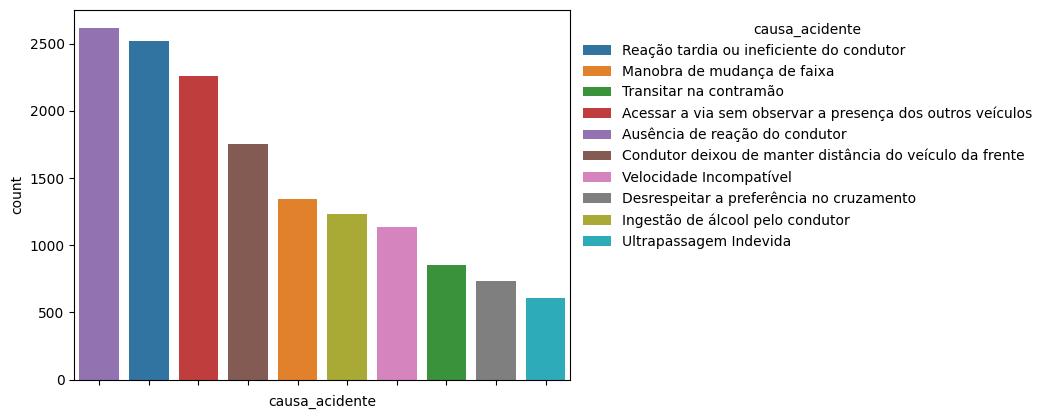

In [22]:
# selecionando as 10 causas mais frequentes e selecionando os datapoints associados

causas = acidentes_sc_colunas_selecionadas['causa_acidente'].value_counts().keys().tolist()[0:10]
data = acidentes_sc_colunas_selecionadas.loc[acidentes_sc_colunas_selecionadas['causa_acidente'].isin(causas)]
plot = sns.countplot(data=data, x='causa_acidente', order=causas, hue='causa_acidente', legend=True)
plot.set(xticklabels=[])
sns.move_legend(plot, 'best', ncol=1, bbox_to_anchor=(1, 1), frameon=False)

## 3.2 Tipo Veículos (top10 mais frequentes)

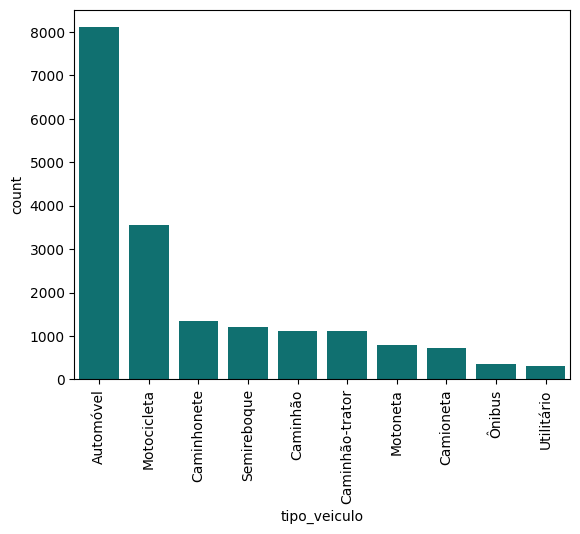

In [23]:
# selecionando os 10 mais frequentes e selecionando os datapoints associados

veiculos = acidentes_sc_colunas_selecionadas['tipo_veiculo'].value_counts().keys().tolist()[0:10]
data = acidentes_sc_colunas_selecionadas.loc[acidentes_sc_colunas_selecionadas['tipo_veiculo'].isin(veiculos)]
plot = sns.countplot(data=data, x='tipo_veiculo', order=veiculos, color='teal')
locs, labels = plt.xticks()
a = plt.setp(labels, rotation=90)

## 3.3 Município (top10 com mais acidentes)

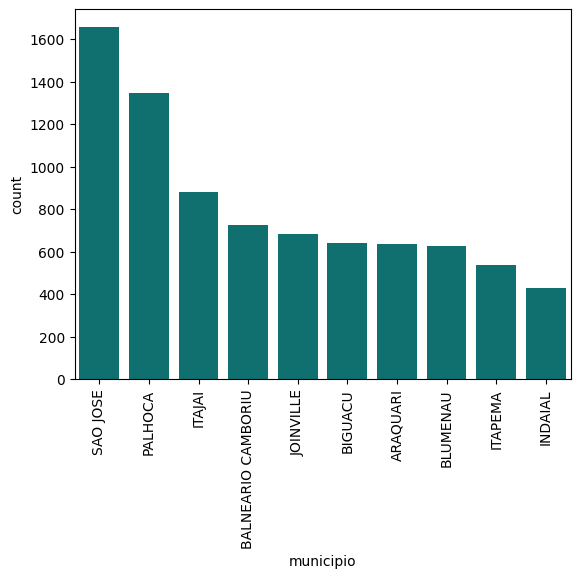

In [24]:
# selecionando os 10 mais frequentes e selecionando os datapoints associados

municipios = acidentes_sc_colunas_selecionadas['municipio'].value_counts().keys().tolist()[0:10]
data = acidentes_sc_colunas_selecionadas.loc[acidentes_sc_colunas_selecionadas['municipio'].isin(municipios)]
plot = sns.countplot(data=data, x='municipio', order=municipios, color='teal')
locs, labels = plt.xticks()
a = plt.setp(labels, rotation=90)

## 3.4 Acidentes Fatais

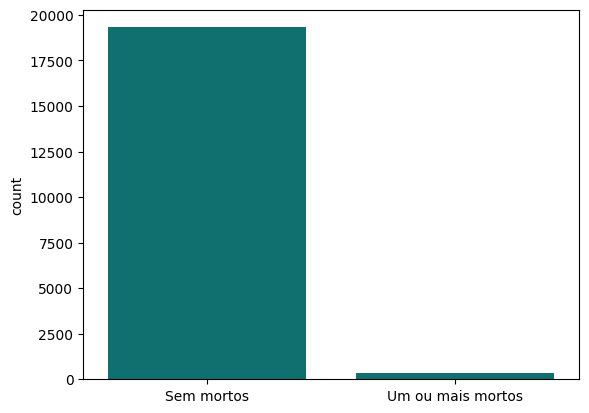

In [25]:
plot = sns.countplot(data=acidentes_sc_colunas_selecionadas, x='mortos', color='teal', legend=True)
a = plot.set(xticklabels=['Sem mortos', 'Um ou mais mortos'])
a = plot.set(xlabel=None)
#plot.set_yscale('log')

No ano passado, em SC, a porcentagem de acidentes fatais em relação ao número total de acidentes foi 1,85%.

## 3.5 Número de Acidentes por Hora e Dia da Semana

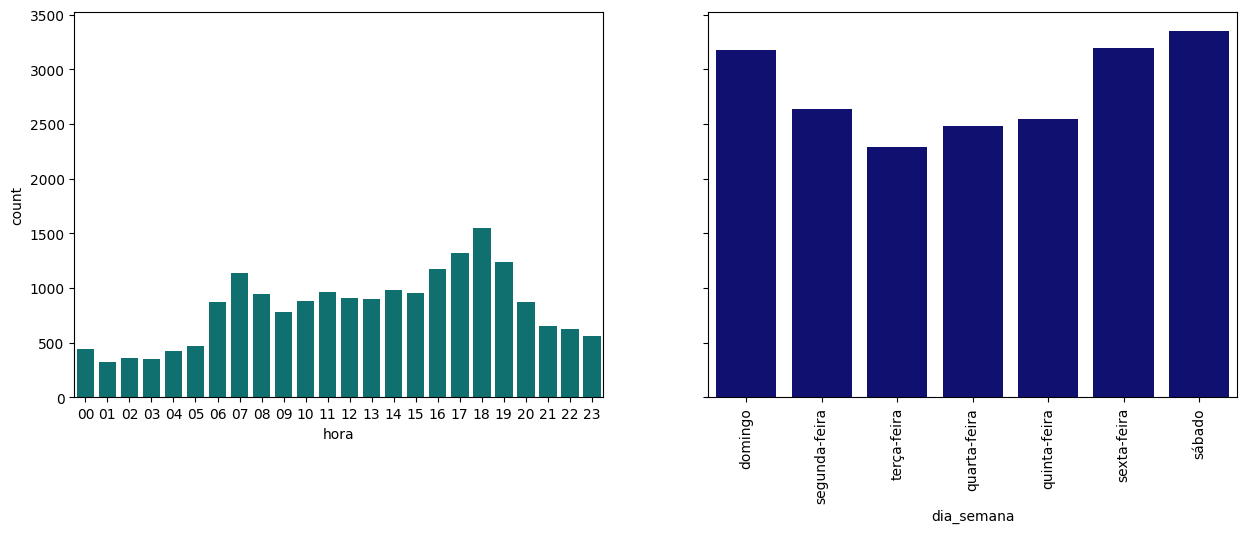

In [26]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey = 'row',figsize = (15, 5))

sns.countplot(data=acidentes_sc_colunas_selecionadas.sort_values(by='hora'), x='hora', ax=ax0, color='teal')
sns.countplot(data=acidentes_sc_colunas_selecionadas.sort_values(by='dia_semana_codificado'), x='dia_semana', ax=ax1, color='navy')
locs, labels = plt.xticks()
a = plt.setp(labels, rotation=90)

## 3.6 Boxplots das Variáveis Numéricas 

Abaixo, calculamos algumas métricas e plotaremos gráficos de caixa para as seguintes variáveis:
- Número de Acidentes por Município;
- Número de Acidentes por Horário;
- Número de Acidentes por Dia da Semana.

### 3.6.1 Número de Acidentes por Município

In [27]:
num_attributes = numero_acidentes_por_municipio.select_dtypes(include=['int64'])
moments_table = show_descriptive_statistics(num_attributes)
moments_table

,attributes,min,max,range,mean,median,std
0,numero_acidentes,1,1658,1657,166.830508,90.5,239.7105


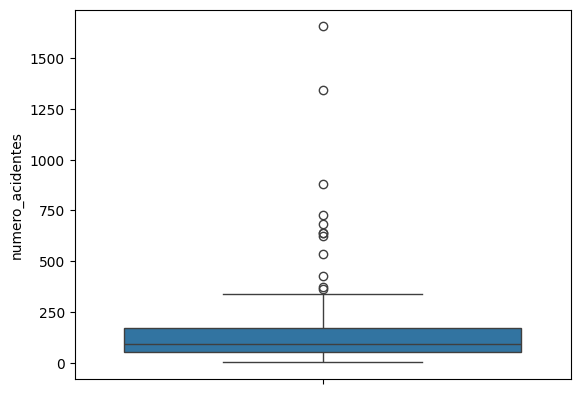

In [28]:
plot = sns.boxplot(data=numero_acidentes_por_municipio, y='numero_acidentes')

### 3.6.2 Número de Acidentes por Horário

In [29]:
num_attributes = numero_acidentes_por_horario.select_dtypes(include=['int64'])
moments_table = show_descriptive_statistics(num_attributes)
moments_table

,attributes,min,max,range,mean,median,std
0,numero_acidentes,320,1548,1228,820.25,880.0,324.920792


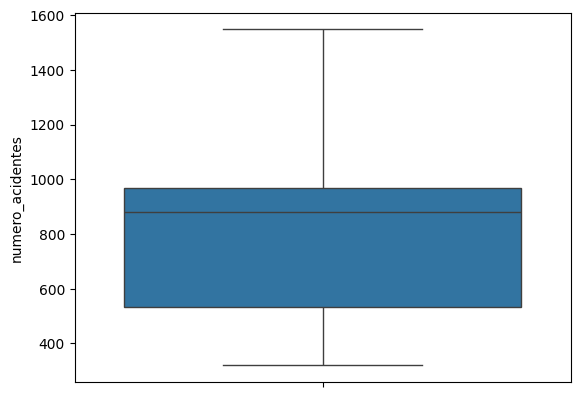

In [30]:
plot = sns.boxplot(data=numero_acidentes_por_horario, y='numero_acidentes')

### 3.6.3 Número de Acidentes por Dia da Semana

In [31]:
num_attributes = numero_acidentes_por_dia_semana.select_dtypes(include=['int64'])
moments_table = show_descriptive_statistics(num_attributes)
moments_table

,attributes,min,max,range,mean,median,std
0,numero_acidentes,2294,3353,1059,2812.285714,2634.0,387.961233


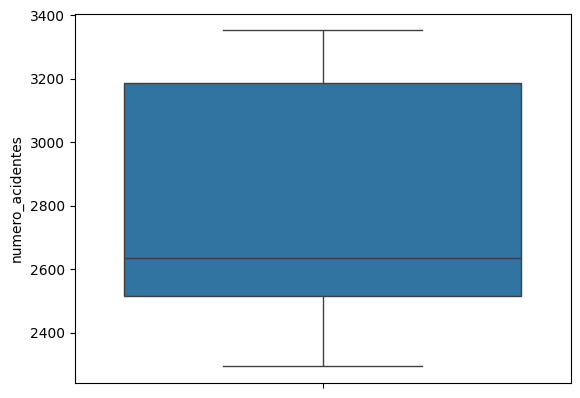

In [32]:
plot = sns.boxplot(data=numero_acidentes_por_dia_semana, y='numero_acidentes')

# 4- Tabelas Bivariadas

## 4.1 Número de Acidentes Fatais por Veículo (top10 veículos)

In [33]:
veiculo = acidentes_sc_colunas_selecionadas['tipo_veiculo'].value_counts().keys().tolist()[0:10]
data = acidentes_sc_colunas_selecionadas.loc[acidentes_sc_colunas_selecionadas['tipo_veiculo'].isin(veiculo)]
mortes_por_veiculo_df = make_number_of_accidents_df(data)
mortes_por_veiculo_df['porcentagem_acidentes_fatais'] = (mortes_por_veiculo_df['acidentes_fatais']/mortes_por_veiculo_df['numero_acidentes'])*100
mortes_por_veiculo_df

,tipo_veiculo,numero_acidentes,acidentes_fatais,porcentagem_acidentes_fatais
0,Caminhão,1106,19,1.717902
1,Caminhão-trator,1106,9,0.813743
2,Semireboque,1199,0,0.000000
3,Automóvel,8105,139,1.714991
4,Motocicleta,3552,89,2.505631
5,Camioneta,713,3,0.420757
6,Utilitário,320,1,0.312500
7,Caminhonete,1344,17,1.264881
8,Motoneta,789,13,1.647655
9,Ônibus,366,1,0.273224


Vemos que o tipo de veículo com maior taxa de acidentes fatais é a motocicleta, com 2.5%. 

# 5. Testes de Hipóteses

Vamos, primeiro, preparar novas tabelas.

## 5.1 Número de acidentes por dia do ano

In [34]:
acidentes_sc_dia_horario = acidentes_sc_1[['data_inversa', 'dia_semana']]
acidentes_sc_dia_horario['data_inversa'] = pd.to_datetime(acidentes_sc_dia_horario['data_inversa'])

In [35]:
n_acidentes_por_dia = []

for data in acidentes_sc_dia_horario['data_inversa'].unique():
    data_df = acidentes_sc_dia_horario.loc[acidentes_sc_dia_horario['data_inversa'] == data]
    n_acidentes = data_df.shape[0]

    n_acidentes_por_dia.append(n_acidentes)

In [36]:
n_acidentes_dict = dict(zip(acidentes_sc_dia_horario['data_inversa'].unique(), n_acidentes_por_dia))
acidentes_sc_dia_horario['numero_acidentes'] = acidentes_sc_dia_horario['data_inversa'].map(n_acidentes_dict)

In [37]:
n_acidentes_por_dia_df = acidentes_sc_dia_horario.drop_duplicates().reset_index(drop=True)
n_acidentes_por_dia_df['final_de_semana'] = n_acidentes_por_dia_df['dia_semana'].apply(
    lambda dia: 1 if dia in ["sexta-feira", "sábado", "domingo"] else 0
)

n_acidentes_por_dia_df

,data_inversa,dia_semana,numero_acidentes,final_de_semana
0,2023-01-02,segunda-feira,81,0
1,2023-01-03,terça-feira,66,0
2,2023-01-04,quarta-feira,78,0
3,2023-01-05,quinta-feira,40,0
4,2023-01-06,sexta-feira,55,1
...,...,...,...,...
360,2023-02-08,quarta-feira,29,0
361,2023-03-12,domingo,53,1
362,2023-04-18,terça-feira,17,0
363,2023-06-20,terça-feira,19,0


## 5.2 Número de acidentes por horário no ano

In [38]:
n_acidentes_por_hora_df = pd.concat([acidentes_sc_dia_horario, acidentes_sc_colunas_selecionadas['hora']], axis=1)
n_acidentes_por_hora_df.drop(['numero_acidentes', 'dia_semana'], axis=1, inplace=True)


In [39]:
n_acidentes_por_hora_df['numero_acidentes_por_dia_por_hora'] = 0

for data in n_acidentes_por_hora_df['data_inversa'].unique():
    data_df = n_acidentes_por_hora_df.loc[n_acidentes_por_hora_df['data_inversa'] == data]

    for hora in data_df['hora'].unique():
        hora_df = data_df.loc[data_df['hora'] == hora]
        n_acidentes = hora_df.shape[0]

        n_acidentes_por_hora_df['numero_acidentes_por_dia_por_hora'].loc[hora_df.index] = n_acidentes

In [40]:
n_acidentes_por_hora_df_1 = n_acidentes_por_hora_df.drop_duplicates().reset_index(drop=True)
n_acidentes_por_hora_df_1['horario_de_pico'] = n_acidentes_por_hora_df_1['hora'].apply(
    lambda hora: 1 if hora in ['08', '09', '10', '11', '12', '13','14','15','16','17', '18', '19'] else 0
)

n_acidentes_por_hora_df_1

,data_inversa,hora,numero_acidentes_por_dia_por_hora,horario_de_pico
0,2023-01-02,07,4,0
1,2023-01-02,17,14,1
2,2023-01-02,22,2,0
3,2023-01-03,06,10,0
4,2023-01-02,04,2,0
...,...,...,...,...
4836,2023-09-12,22,2,0
4837,2023-06-11,13,7,1
4838,2023-06-01,05,2,0
4839,2023-12-26,18,2,1


## 5.3 Hipóteses

### 5.3.1 Sobre média

#### 5.3.1.1 Sobre dias da semana

Vamos primeiro considerar algumas hipóteses sobre médias de número de acidentes por dia entre diferentes dias da semana. As hipóteses serão as seguintes:
- H_0: A média do número de acidentes é a mesma entre todos os dias (hipótese nula do ANOVA).
- H_1: A média do número de acidentes diferente entre os diferentes dias da semana.

In [41]:
f_statistic, p_value, class_degf, res_degf = get_anova_table(n_acidentes_por_dia_df, 'numero_acidentes', 'dia_semana')

print(f"A estatística F é igual a: {f_statistic}")
print(f"O p-valor é igual a: {p_value}")
print(f"Os graus de liberdade são: ({class_degf}, {res_degf})")

A estatística F é igual a: 12.628068997721074
O p-valor é igual a: 6.238235947294736e-13
Os graus de liberdade são: (6.0, 358.0)


Dados os valores acima, concluímos que há uma diferença considerável entre as médias dos diferentes grupos (dias de semana). Além disto, tal p-valor nos diz que há forte evidência estatística para descartar a hipótese nula. Ou seja, temos base para afirmar que a diferença de número de acidentes entre diferentes dias da semanas é bastante significativa.

Agora, separaremos sexta, sábado e domingo em um grupo 'fim de semana', e testaremos as seguintes hipóteses utilizando ANOVA:

- H_0: A média do número de acidentes nos finais de semana é igual à média dos demais dias (hipótese nula do ANOVA).
- H_1: A média do número de acidentes nos finais de semana é diferente dos demais dias.

In [42]:
f_statistic, p_value, class_degf, res_degf = get_anova_table(n_acidentes_por_dia_df, 'numero_acidentes', 'final_de_semana')

print(f"A estatística F é igual a: {f_statistic}")
print(f"O p-valor é igual a: {p_value}")
print(f"Os graus de liberdade são: ({class_degf}, {res_degf})")

A estatística F é igual a: 68.5598983260684
O p-valor é igual a: 2.3888105153594746e-15
Os graus de liberdade são: (1.0, 363.0)


Vemos que o valor da estatística F é ainda superior ao das hipóteses anteriores, e o p-valor menor. Portanto temos evidências estatísticas robustas para dizer que a diferença do número de acidentes entre finais de semana e dias de semana é bastante significativa.

Note que as hipóteses alternativas tomadas acima só dizem respeito ao fato das médias serem diferentes entre os grupos, mas não dizem nada sobre de que modo elas diferem (qual é maior ou menor). Verificaremos isso através das visualizações a seguir.

<Axes: xlabel=' ', ylabel='numero_acidentes'>

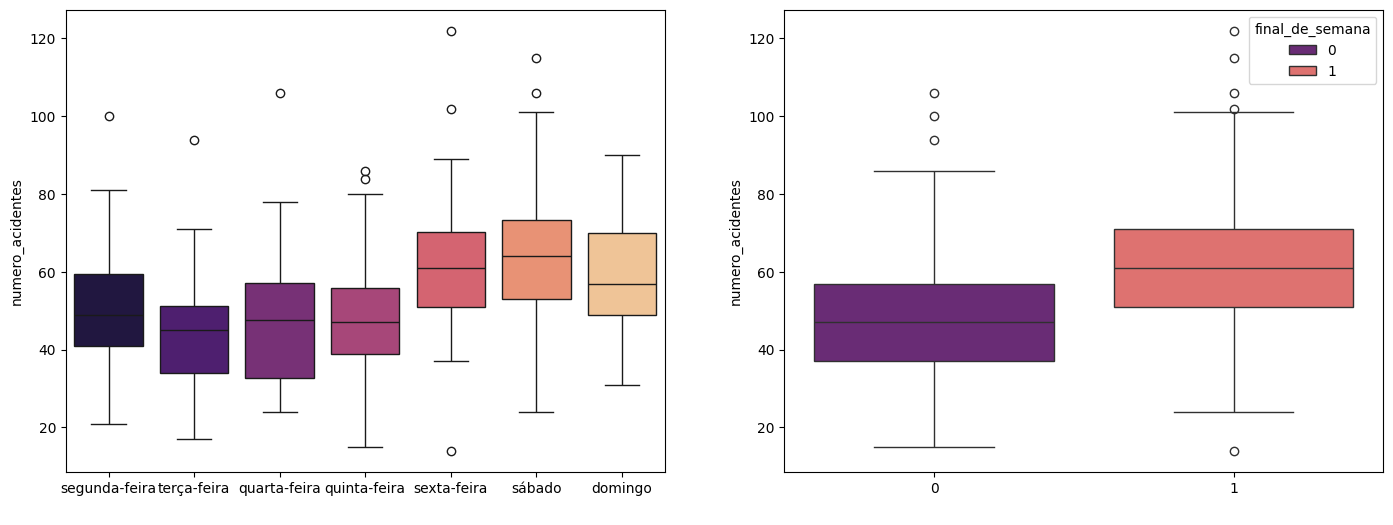

In [50]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (17,6))
ax0.set_xlabel(' ')
ax1.set_xlabel(' ')

sns.boxplot(data=n_acidentes_por_dia_df,
             x='dia_semana',
             y='numero_acidentes',
             hue='dia_semana',
             palette='magma',
             ax=ax0)

sns.boxplot(data=n_acidentes_por_dia_df,
             x='final_de_semana',
             y='numero_acidentes',
             hue='final_de_semana',
             palette='magma',
             ax=ax1)

#### 5.3.1.2 Sobre horários de tráfego

Neste ponto, vamos considerar as seguintes hipóteses sobre os diferentes intervalos de hora (00h-01h, 01h-02h, ...):

- H_0: A média do número de acidentes é a mesma entre todos os horários (hipótese nula do ANOVA).
- H_1: A média do número de acidentes diferente entre os diferentes intervalos de hora.

In [43]:
f_statistic, p_value, class_degf, res_degf = get_anova_table(n_acidentes_por_hora_df_1, 'numero_acidentes_por_dia_por_hora', 'hora')

print(f"A estatística F é igual a: {f_statistic}")
print(f"O p-valor é igual a: {p_value}")
print(f"Os graus de liberdade são: ({class_degf}, {res_degf})")

A estatística F é igual a: 9.412132990782524
O p-valor é igual a: 1.4374611494012707e-32
Os graus de liberdade são: (23.0, 4817.0)


Dados os valores acima, podemos descartar a hipótese nula com bastante evidência estatística.

Agora, vamos considerar as seguintes hipóteses sobre intervalos de hora específicos considerados como horário de pico em SC, a saber, 08h às 20h. 

- H_0: A média do número de acidentes é a mesma entre os intervalos definidos e os demais (hipótese nula do ANOVA).
- H_1: A média do número de acidentes diferente entre os intervalos definidos e os demais.

In [44]:
f_statistic, p_value, class_degf, res_degf = get_anova_table(n_acidentes_por_hora_df_1, 'numero_acidentes_por_dia_por_hora', 'horario_de_pico')

print(f"A estatística F é igual a: {f_statistic}")
print(f"O p-valor é igual a: {p_value}")
print(f"Os graus de liberdade são: ({class_degf}, {res_degf})")

A estatística F é igual a: 100.17163444290745
O p-valor é igual a: 2.354252603160759e-23
Os graus de liberdade são: (1.0, 4839.0)


Mais uma vez, há forte evidência estatística para descartar a hipótese nula. Confirmamos isso nas seguintes visualizações.

<Axes: xlabel=' ', ylabel='numero_acidentes_por_dia_por_hora'>

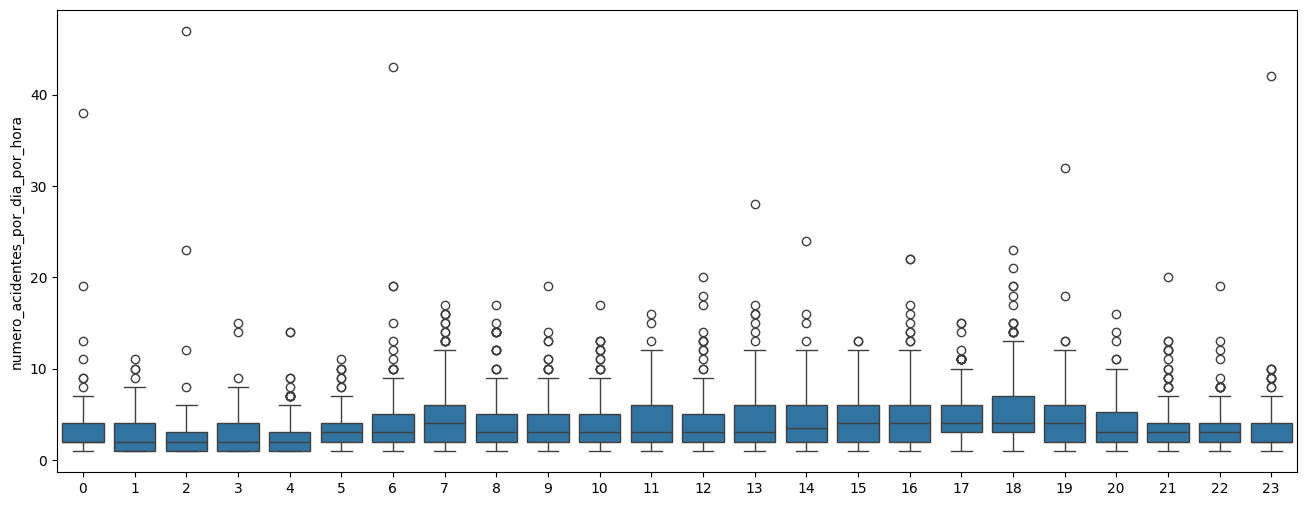

In [65]:
fig, ax0 = plt.subplots(1, 1, figsize = (16,6))
ax0.set_xlabel(' ')


sns.boxplot(data=n_acidentes_por_hora_df_1.sort_values('hora'),
             x='hora',
             y='numero_acidentes_por_dia_por_hora',             
             ax=ax0)

<Axes: xlabel=' ', ylabel='numero_acidentes_por_dia_por_hora'>

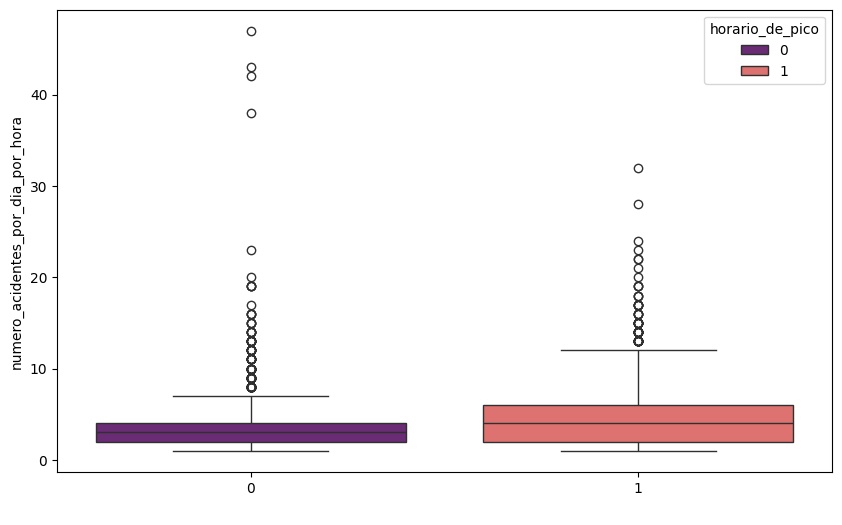

In [66]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 6))
ax1.set_xlabel(' ')

sns.boxplot(data=n_acidentes_por_hora_df_1,
             x='horario_de_pico',
             y='numero_acidentes_por_dia_por_hora',
             hue='horario_de_pico',
             palette='magma',             
             ax=ax1)

### 5.3.2 Sobre proporções

Selecionaremos agora alguns períodos específicos do ano para teste de proporção. Dado um período, verificaremos se a distribuição de acidentes neste tem a mesma proporção que a proporção geral.

Selecionamos primeiro os dias entre 14/02/2023 e 21/02/2023, que engloba o feriado de Carnaval. As hipóteses serão as seguintes:

- H_0 = a proporção de acidentes no final de semana, para esse período, é a mesma da proporção geral.
- H_1 = a proporção de acidentes no final de semana, para esse período, é maior que a proporção geral.

In [45]:
mask = (n_acidentes_por_dia_df['data_inversa'] > '2023-02-14') & (n_acidentes_por_dia_df['data_inversa'] <= '2023-02-21')
semana_carnaval = n_acidentes_por_dia_df.loc[mask]
semana_carnaval

,data_inversa,dia_semana,numero_acidentes,final_de_semana
43,2023-02-15,quarta-feira,50,0
44,2023-02-16,quinta-feira,53,0
45,2023-02-17,sexta-feira,49,1
46,2023-02-18,sábado,63,1
47,2023-02-19,domingo,82,1
48,2023-02-20,segunda-feira,63,0
49,2023-02-21,terça-feira,47,0


Tomamos aqui a proporção de acidentes no fim de semana em relação ao total para esse período específico.

In [46]:
finde_df = semana_carnaval.loc[semana_carnaval['final_de_semana'] == 1]
n_acidentes_finde = np.sum(finde_df['numero_acidentes'])
n_acidentes = np.sum(semana_carnaval['numero_acidentes'])

proporcao_acidentes_finde_carnaval = n_acidentes_finde/n_acidentes
print(f'A proporção de acidentes no final de semana deste período é: {proporcao_acidentes_finde_carnaval}')

A proporção de acidentes no final de semana deste período é: 0.47665847665847666


Abaixo, tomamos a proporção de acidentes que ocorrem no fim de semana em relação ao número total de acidentes.

In [47]:
finde_df = n_acidentes_por_dia_df.loc[n_acidentes_por_dia_df['final_de_semana'] == 1]
n_acidentes_finde = np.sum(finde_df['numero_acidentes'])
n_acidentes = np.sum(n_acidentes_por_dia_df['numero_acidentes'])

proporcao_acidentes_finde = n_acidentes_finde/n_acidentes
print(f'A proporção de acidentes no final de semana é: {proporcao_acidentes_finde}')

A proporção de acidentes no final de semana é: 0.4941582850756883


In [48]:
total_acidentes_carnaval = np.sum(semana_carnaval['numero_acidentes'])

z_statistic = (proporcao_acidentes_finde_carnaval - proporcao_acidentes_finde) / np.sqrt(
        proporcao_acidentes_finde * (1 - proporcao_acidentes_finde) / total_acidentes_carnaval 
    )

p_value = 2 * (1 - stats.norm.cdf(abs(z_statistic)))

print(f"A estatística Z é igual a: {z_statistic}")
print(f"O p-valor é igual a: {p_value}")

A estatística Z é igual a: -0.7061389015085884
O p-valor é igual a: 0.4801017617224814


Dos valores acima, não temos suporte estatístico para descartar a hipótese nula, ou seja, a hipótese de que a proporção de acidentes no final de semana de Carnaval é igual à dos demais.

### 5.3.3 Sobre regressão linear

Nesta seção, vamos investigar se há relação linear significativa entre a variável 'hora' e o número de acidentes médio. Lembrando que a hipótese nula sobre o coeficiente angular é a hipótese de que ele vale 0.

In [63]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    n_acidentes_por_hora_df_1['hora'], 
    n_acidentes_por_hora_df_1['numero_acidentes_por_dia_por_hora']
)

print(f"Coeficiente angular da reta: {slope}")
print(f"Interceptação: {intercept}")
print(f"R-quadrado: {r_value**2}")
print(f"p-valor: {p_value}")
print(f"Desvio padrão: {std_err}")

Coeficiente angular da reta: 0.04716966003993699
Interceptação: 3.478867548645197
R-quadrado: 0.008818588277877125
p-valor: 5.886102475214078e-11
Desvio padrão: 0.007188892281968495


Nesta situação, o p-valor nos dá suporte para afirmar que o coeficiente angular obtido é estatisticamente significativo, ou seja, o intervalo de confiança para descartar a hipótese nula sobre o coeficiente angular é muito alto (virtualmente 100%). <br>
Porém, temos que também levar em consideração o baixo valor para o R-quadrado. Isto nos diz que muito pouco da variação na variável alvo, somente 0,9%, pode ser explicado pelo modelo linear. Ou seja, na prática parece que o modelo linear da variável dependendo não nos é útil para explicar a variável alvo.

Abaixo, vamos apresentar o coeficiente de Pearson para as duas variáveis em questão, além de plotar um gráfico de dispersão em conjunto com o modelo linear obtido.

In [64]:
correlation, p_value = stats.pearsonr(
    n_acidentes_por_hora_df_1['hora'], 
    n_acidentes_por_hora_df_1['numero_acidentes_por_dia_por_hora']
)

print(f"Coeficiente de correlação de Pearson: {correlation}")
print(f"p-valor: {p_value}")

Coeficiente de correlação de Pearson: 0.09390733878604564
p-valor: 5.88610247521374e-11


<Axes: xlabel='hora', ylabel='numero_acidentes_por_dia_por_hora'>

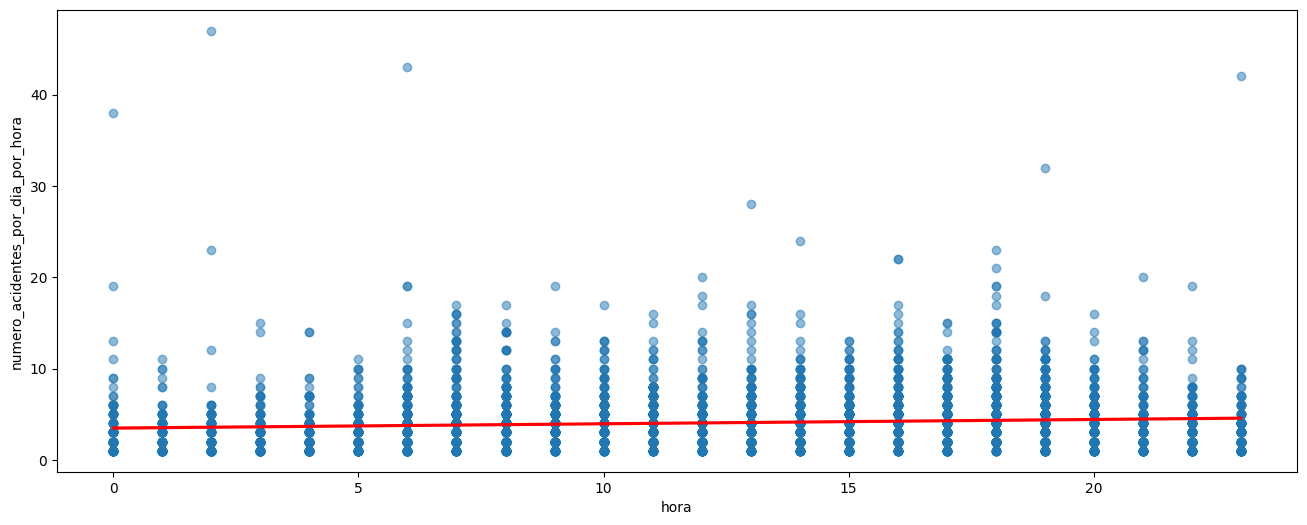

In [ ]:
n_acidentes_por_hora_df_1['hora'] = pd.to_numeric(n_acidentes_por_hora_df_1['hora'], errors='coerce')

fig, ax0 = plt.subplots(1, 1, figsize = (16,6))
ax0.set_xlabel(' ')

sns.regplot(data=n_acidentes_por_hora_df_1.sort_values('hora'), 
            x='hora', 
            y='numero_acidentes_por_dia_por_hora', 
            ax=ax0,
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'})

Do baixo valor para o coeficiente de Pearson, e principalmente da visualização, confirmamos que o modelo linear entre as duas variáveis não é bom o suficiente para explicar a relação entre as duas variáveis.